In [1]:
import pandas as pd
import random
import plotly.graph_objects as go
import plotly.express as px
import yaml
import os
import datetime as dt
import math
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

(link to dataset)[https://dataverse.harvard.edu/dataset.xhtml?id=3047332]

In [2]:
tweets_df = pd.read_csv('./top-20-tweets-2017.csv')

In [3]:
tweets_df.shape

(52542, 10)

In [4]:
tweets_df.dtypes

author               object
content              object
country              object
date_time            object
id                  float64
language             object
latitude            float64
longitude           float64
number_of_likes       int64
number_of_shares      int64
dtype: object

In [5]:
print(
    tweets_df.date_time.min()
    , tweets_df.date_time.max()
)

01/01/2011 02:16 31/12/2016 23:59


In [6]:
tweets_df.sample(10)

author                                            content  \
19616   TheEllenShow  Check out my new neon mugs in the Ellen Shop. ...   
2156       katyperry               @shayoch9 Omg you're a little qewty!   
6309   taylorswift13    Then and now. @britmaack http://t.co/BhNauc93TG   
35814    selenagomez  @Arianalover110 Not sure who is more excited y...   
36207    selenagomez  Happy early Valentines Day everyone, I am send...   
34759    selenagomez  Daddy and daughter date #spurs ☺️🙏 http://t.co...   
24916    jtimberlake  CONGRATS! The brand new #TakeBackTN video is n...   
714        katyperry  ...it will be a continually interactive space ...   
42583   ArianaGrande  @intoyoubeer everyone would actually drop dead...   
8062     BarackObama  "We've led by example, generating more clean e...   

      country         date_time            id language  latitude  longitude  \
19616     NaN  08/03/2016 21:33  7.073180e+17       en       NaN        NaN   
2156      NaN  22/10/2013 18:55  3.927260e+17       en       NaN        NaN   
6309      NaN  23/06/2013 20:52  3.489060e+17       en       NaN        NaN   
35814     NaN  03/04/2013 19:30  3.195320e+17       en       NaN        NaN   
36207     NaN  07/02/2012 19:59  1.669740e+17       en       NaN        NaN   
34759     NaN  15/11/2014 04:43  5.334800e+17       en       NaN        NaN   
24916     NaN  30/07/2013 15:13  3.622290e+17       en       NaN        NaN   
714       NaN  18/12/2015 22:14  6.779750e+17       en       NaN        NaN   
42583     NaN  20/09/2016 22:41  7.783630e+17       en       NaN        NaN   
8062      NaN  24/10/2015 17:58  6.579790e+17       en       NaN        NaN   

       number_of_likes  number_of_shares  
19616             3044               329  
2156               729               536  
6309             38963             25543  
35814              853              1219  
36207             1979              4628  
34759            14652              9143  
24916              710              1308  
714               6420              2504  
42583             8477              2613  
8062              2274               900

In [7]:
tweets_df.author.unique()

array(['katyperry', 'justinbieber', 'taylorswift13', 'BarackObama',
       'rihanna', 'YouTube', 'ladygaga', 'TheEllenShow', 'Twitter',
       'jtimberlake', 'KimKardashian', 'britneyspears', 'Cristiano',
       'selenagomez', 'cnnbrk', 'jimmyfallon', 'ArianaGrande', 'shakira',
       'instagram', 'ddlovato'], dtype=object)

In [8]:

analyser = SentimentIntensityAnalyzer()

In [9]:
sample_tweets = tweets_df.content.sample(1000).values
sample_scores = []
for tweet in sample_tweets:
    sample_scores.append(analyser.polarity_scores(tweet))
    
df = pd.DataFrame(data = {'tweet': sample_tweets, 'vader_score': sample_scores})
df['sample_compound_score'] = df.vader_score.apply(lambda x: x['compound'])
    

In [10]:
tweets_df['vader_score'] = tweets_df.content.apply(lambda x: analyser.polarity_scores(x))

In [11]:
tweets_df['compound_score'] = tweets_df.vader_score.apply(lambda x: x['compound'])
tweets_df['datetime'] = pd.to_datetime(tweets_df.date_time)
    

In [12]:
## is it really this easy to just get the happiness lexicon from the hedonometer
import requests


r = requests.get("http://hedonometer.org/api/v1/words/?format=json&wordlist__title=labMT-en-v2")

In [13]:
import json

json_data = json.loads(r.text)

In [14]:
# create hedonometer dict
hed_dict = {}

for obj in json_data['objects']:
    hed_dict[obj['word']] = obj

In [15]:
# random sample of hed_dict
keys = random.sample(list(hed_dict),10)

for k in keys:
    print(k, hed_dict[k])

cars {'happs': 6.26, 'rank': 1840, 'stdDev': 1.69, 'text': 'cars', 'word': 'cars', 'word_english': 'cars', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://arxiv.org/abs/2003.12614', 'referencetitle': "How the world's collective attention is being paid to a pandemic: COVID-19 related 1-gram time series for 24 languages on Twitter", 'title': 'labMT-en-v2'}}
gotta {'happs': 5.02, 'rank': 7067, 'stdDev': 1.19, 'text': 'gotta', 'word': 'gotta', 'word_english': 'gotta', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://arxiv.org/abs/2003.12614', 'referencetitle': "How the world's collective attention is being paid to a pandemic: COVID-19 related 1-gram time series for 24 languages on Twitter", 'title': 'labMT-en-v2'}}
knows {'happs': 6.12, 'rank': 2256, 'stdDev': 0.9, 'text': 'knows', 'word': 'knows', 'word_english': 'knows', 'wordlist': {'date': '2020-03-28', 'language': 'en', 'reference': 'https://arxiv.org/abs/2003.12614', 'referencetitl

In [16]:
# clean words are words defined in hednometer lexicon
def get_word_ct(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(wrd)
            else:
                res.append(wrd)
                    
    return len(res)
    
# get sum of clean word scores
def get_total_word_score(x, dict, tune_delta=None):
    res = []
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res.append(dict[wrd.lower()]['happs'])
            else:
                res.append(dict[wrd.lower()]['happs'])
                    
    return sum(res)

def get_hedonometer_word_dict(x, dict,  tune_delta=None):
    res = {'words':{}, 'freq':0}
    for wrd in str(x).split():
        if wrd.lower() in dict.keys():
            if tune_delta:
                if abs(dict[wrd.lower()]['happs'] - 5) > tune_delta:
                    res['words'][wrd] = dict[wrd.lower()]['happs']
                    res['freq'] += 1
            else:
                res['words'][wrd] = dict[wrd.lower()]['happs']
                res['freq'] += 1
                    
    return res


# delta 1
tweets_df['hedonometer_frequency'] = tweets_df.content.apply(lambda x: get_word_ct(x, hed_dict,1))
tweets_df['hedonometer_total_score'] = tweets_df.content.apply(lambda x: get_total_word_score(x, hed_dict,1))
tweets_df['hedonometer_score'] = tweets_df.hedonometer_total_score/tweets_df.hedonometer_frequency
tweets_df['hedonometer_dict'] = tweets_df.content.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

tweets_df.iloc[random.sample(range(100),1)]

author              content country         date_time            id  \
51  katyperry  POWER TO THE PEOPLE     NaN  09/11/2016 08:10  7.962640e+17   

   language  latitude  longitude  number_of_likes  number_of_shares  \
51       en       NaN        NaN            31136             13120   

                                          vader_score  compound_score  \
51  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...             0.0   

              datetime  hedonometer_frequency  hedonometer_total_score  \
51 2016-09-11 08:10:00                      2                    12.84   

    hedonometer_score                                   hedonometer_dict  
51               6.42  {'words': {'POWER': 6.68, 'PEOPLE': 6.16}, 'fr...

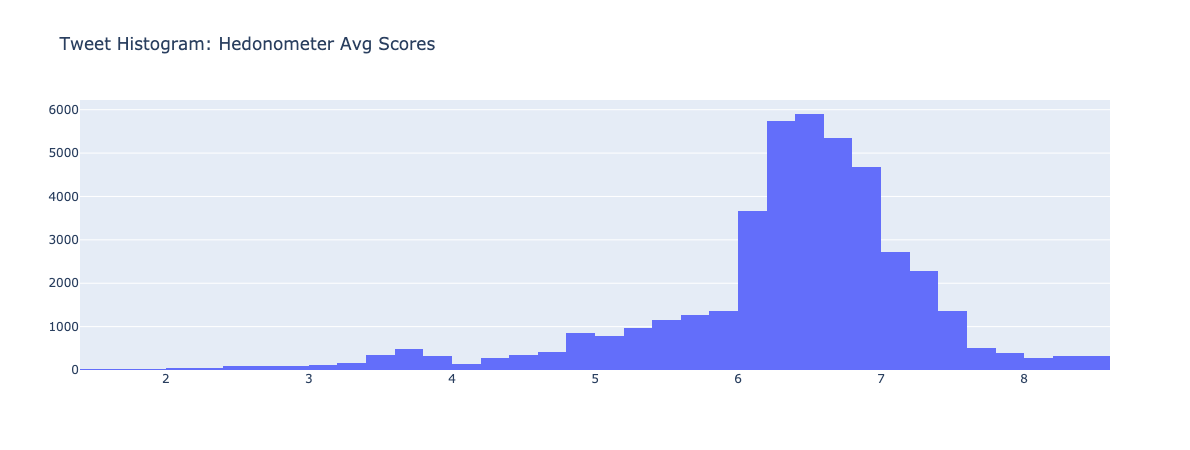

In [17]:
# histogram of hedonometer tweet scores without tuning 
fig = go.Figure({'data':[
    go.Histogram(x=tweets_df['hedonometer_score'], nbinsx=50)
]
                , 'layout': {"title": {"text": "Tweet Histogram: Hedonometer Avg Scores"}}
                }  
               )
fig.show()

In [18]:
### happiness vs sentiment in 2015
hed_score_adj = 5
tweets_df['compound_score_normalized'] = (tweets_df.compound_score - tweets_df.compound_score.mean())/tweets_df.compound_score.std()
tweets_df['hedonometer_score_normalized'] = (tweets_df.hedonometer_score - tweets_df.hedonometer_score.mean())/tweets_df.hedonometer_score.std()

by_day_df = tweets_df[tweets_df.datetime.dt.year==2015].groupby(tweets_df.datetime.dt.date).agg(
    {
        'hedonometer_score_normalized': 'mean'
        , 'compound_score_normalized': 'mean'
    }
)

by_day_df.head(20)

hedonometer_score_normalized  compound_score_normalized
datetime                                                           
2015-01-01                      0.164811                   0.178623
2015-01-02                      0.095197                   0.193364
2015-01-03                      0.022497                   0.295147
2015-01-04                      0.131868                  -0.082989
2015-01-05                      0.332464                   0.116415
2015-01-06                     -0.027722                   0.156442
2015-01-07                      0.305301                   0.176893
2015-01-08                      0.414372                   0.138017
2015-01-09                      0.015045                   0.012476
2015-01-10                      0.232600                   0.043405
2015-01-11                      0.116567                   0.270440
2015-01-12                     -0.001123                   0.104330
2015-01-13                     -0.196732                   0.225899
2015-01-14                     -0.346739                  -0.462950
2015-01-15                     -0.019919                  -0.185486
2015-01-16                      0.154296                  -0.192736
2015-01-17                      0.096927                   0.065527
2015-01-18                      0.154410                  -0.025259
2015-01-19                     -0.194776                  -0.022537
2015-01-20                     -0.151416                   0.102619

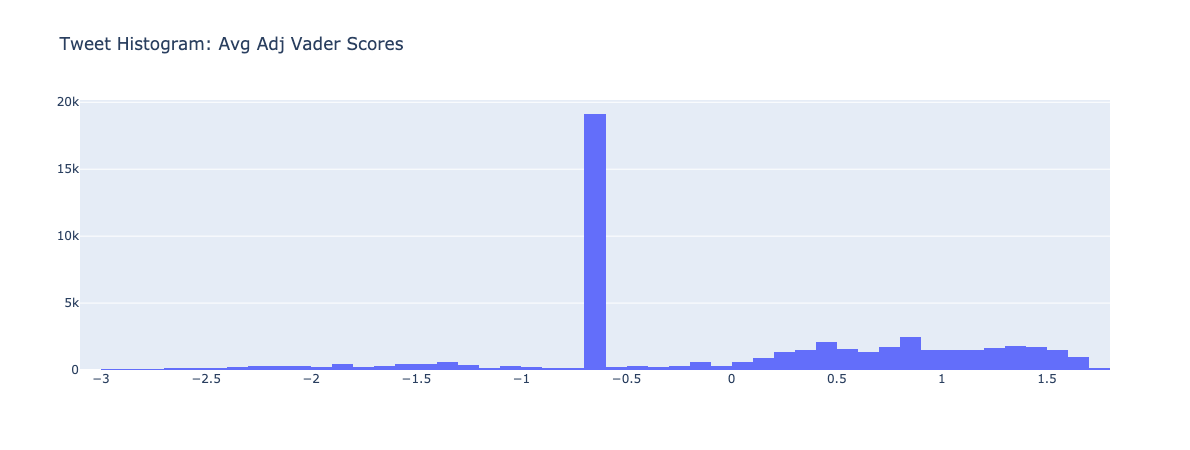

In [19]:
fig = go.Figure({'data':[
    go.Histogram(x=tweets_df['compound_score_normalized'], nbinsx=50)
]
                , 'layout': {"title": {"text": "Tweet Histogram: Avg Adj Vader Scores"}}
                }  
               )
fig.show()

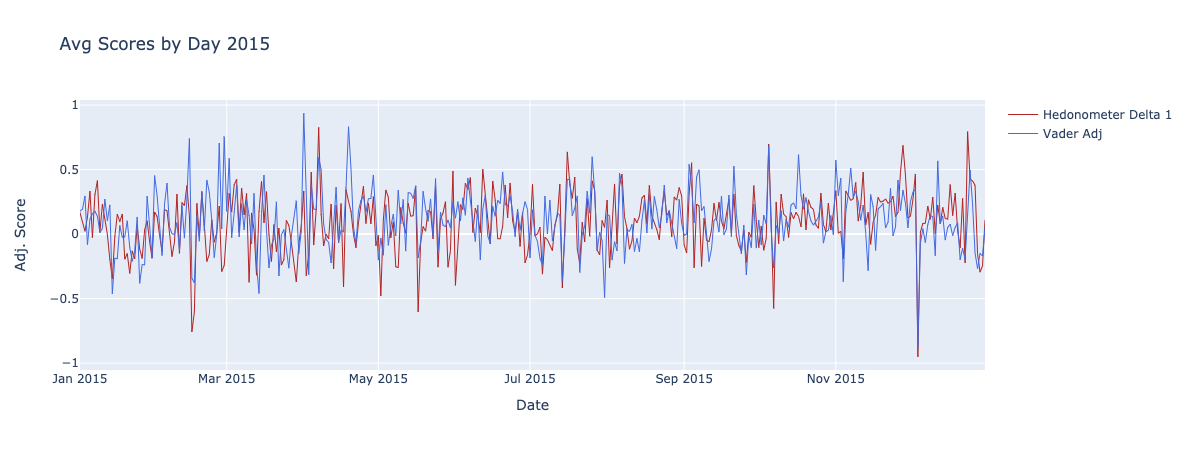

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.hedonometer_score_normalized
    , name='Hedonometer Delta 1'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=by_day_df.index.values
    , y=by_day_df.compound_score_normalized
    , name='Vader Adj'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='Avg Scores by Day 2015',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

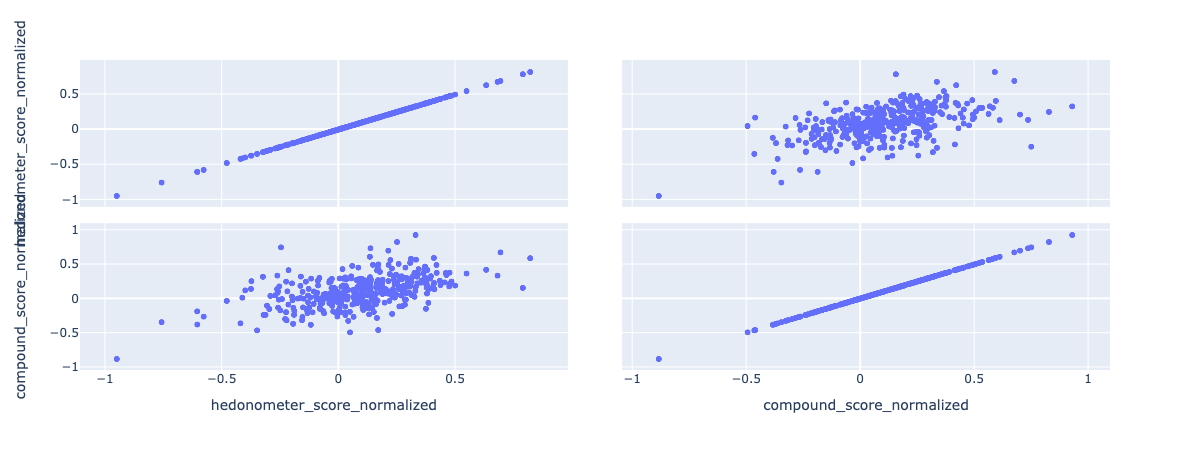

In [21]:
fig = px.scatter_matrix(by_day_df,
    dimensions=['hedonometer_score_normalized','compound_score_normalized'])
fig.show()

In [22]:
import scipy.stats as stats

stats.pearsonr(by_day_df.compound_score_normalized, by_day_df.hedonometer_score_normalized)

(0.5142342795057707, 4.9979979719478966e-26)

[great guide for using python requests and twitter api](https://benalexkeen.com/interacting-with-the-twitter-api-using-python/)

In [23]:
# api creds
creds = yaml.load(
    open(os.path.expanduser('~/.twitter/creds.yml')), 
    Loader=yaml.FullLoader)

client_key = creds['api-key']
client_secret = creds['api-secret']

import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')

In [24]:
import requests

base_url = 'https://api.twitter.com/'
auth_url = '{}oauth2/token'.format(base_url)

auth_headers = {
    'Authorization': 'Basic {}'.format(b64_encoded_key),
    'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'
}

auth_data = {
    'grant_type': 'client_credentials'
}

In [25]:
auth_resp = requests.post(auth_url, headers=auth_headers, data=auth_data)

auth_resp.text

'{"token_type":"bearer","access_token":"AAAAAAAAAAAAAAAAAAAAAJB%2FKQEAAAAABsWmHWYhsQXu%2BwwIq53cvcfmSy8%3DMRiRXUtQ2vPWGbJRyNKtzm6dCgRthdcFGmo4p9ZQbpniVjulyq"}'

In [26]:
access_token = auth_resp.json()['access_token']

In [27]:
# # v 2 api
# # 225 requests per 15-minute window, 1 request every 2 seconds
# end_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30)).isoformat()) + 'Z'
# start_time = str((dt.datetime.utcnow() - dt.timedelta(days=1, minutes=30)).isoformat()) + 'Z'



# search_headers = {
#     'Authorization': 'Bearer {}'.format(access_token)    
# }

# search_params = {
#     'query': 'entity: United States -is:retweet',
#     'max_results': 100, 
#     'end_time': end_time,
#     'start_time': start_time,
#     'tweet.fields': 'created_at,lang',
#     'user.fields': 'username,description',
#     'place.fields': 'country,geo',
    
# }

# search_url = '{}2/tweets/search/recent'.format(base_url)

# search_resp = requests.get(search_url, headers=search_headers, params=search_params)
# tweet_data = search_resp.json()
# print(tweet_data.keys())
# print(len(tweet_data['data']))

# # random sample of tweets
# for obj in random.sample(tweet_data['data'],10):
#     print(str(obj) + '\n')


In [30]:
### let's get a bunch of tweets for the trailing 5 days
# bewary of 450 per 15 limit
import time

tweets = []
for i in range(24*5*2):
    end_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30 + 30 * i)).isoformat()) + 'Z'
    start_time = str((dt.datetime.utcnow() - dt.timedelta(minutes=30 + 30 * (i + 1))).isoformat()) + 'Z'



    search_headers = {
        'Authorization': 'Bearer {}'.format(access_token)    
    }

    search_params = {
        'query': 'entity: United States -is:retweet',
        'max_results': 100, 
        'end_time': end_time,
        'start_time': start_time,
        'tweet.fields': 'created_at,lang',
        'user.fields': 'username,description',
        'place.fields': 'country,geo',

    }

    search_url = '{}2/tweets/search/recent'.format(base_url)

    search_resp = requests.get(search_url, headers=search_headers, params=search_params)
    tweet_data = search_resp.json()
    
#     print(dt.datetime.utcnow(), start_time, end_time, len(tweet_data['data']))
    if 'data' in tweet_data.keys():
        tweets = tweets + tweet_data['data']

    

In [31]:
tweet_data.keys()

dict_keys(['data', 'meta'])

In [32]:
print(len(tweets))
tweets[0]

2318


{'lang': 'en',
 'created_at': '2020-12-17T04:24:47.000Z',
 'id': '1339426291339112448',
 'text': "I've heard from some people that think Mexico's capital is Spain and no, Spain is in Europe, Mexico in America (the American continent the country is United states) and the vast majority of the country Spain is fucking white, the exceptions are black people and some brown people"}

In [33]:
tdf = pd.DataFrame(data=tweets)

In [34]:
tdf['hedonometer_frequency'] = tdf.text.apply(lambda x: get_word_ct(x, hed_dict,1))
tdf['hedonometer_total_score'] = tdf.text.apply(lambda x: get_total_word_score(x, hed_dict,1))
tdf['hedonometer_score'] = tdf.hedonometer_total_score/tdf.hedonometer_frequency

tdf['vader_score'] = tdf.text.apply(lambda x: analyser.polarity_scores(x)['compound'])

tdf['hedonometer_score_normalized'] = (tdf.hedonometer_score - tdf.hedonometer_score.mean())/tdf.hedonometer_score.std()
tdf['vader_score_normalized'] = (tdf.vader_score - tdf.vader_score.mean())/tdf.vader_score.std()

tdf['hedonometer_dict'] = tdf.text.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

tdf['score_delta'] = abs(tdf.hedonometer_score_normalized - tdf.vader_score_normalized)

In [35]:
tdf['datetime'] = pd.to_datetime(tdf.created_at)

In [36]:
for ix in tdf[tdf.hedonometer_score_normalized>0].sort_values(by='score_delta', ascending=False).head(10).index.values:
    print(
        tdf.text.iloc[ix], 
        tdf.hedonometer_score_normalized.iloc[ix], 
        tdf.vader_score_normalized.iloc[ix],
        tdf.hedonometer_score.iloc[ix],
        tdf.hedonometer_dict[ix]
    )

@derekmaltz_sr America has become the United (Fraudulent) States of America. Shameless and shameful @senatemajldr McConnell. 1.2632604305139954 -1.906473004522386 7.04 {'words': {'America': 6.76, 'United': 7.32}, 'freq': 2}
Michele Lujan Grissum embezzled money from the government spaceport embezzlement act devastated the u.s. economy collapsed by the u.s. government Michele Lujan Grissum and NM government and judges RICO Racketeering Influence corrupt Organization of the United states of America193 1.615744485205205 -1.514818613684363 7.3100000000000005 {'words': {'money': 7.3, 'United': 7.32}, 'freq': 2}
Fuck the police,  fuck the FBI,  fuck the government of the United states.  Corrupt from the bottom up. We will this fight. The future belong to us to the people. 0.6209561530766802 -2.2363070680289017 6.547999999999999 {'words': {'United': 7.32, 'We': 6.38, 'will': 6.02, 'future': 6.76, 'us': 6.26}, 'freq': 5}
@ckmarie @DaniellaMicaela That's what the United states are assholes 1.62

In [37]:
### getting overall happiness from hedonometer
uri = 'http://hedonometer.org/api/v1/happiness/?format=json&timeseries__title=en_all&date__gte=2015-01-01'
r = requests.get(uri)
hed_df = pd.DataFrame(json.loads(r.content)['objects'])
hed_df.sort_values('date', inplace=True)
hed_df['datetime'] = pd.to_datetime(hed_df.date)

hed_df.tail()

date    frequency happiness             timeseries   datetime
2171  2020-12-11  181206755.0     5.933  /api/v1/timeseries/3/ 2020-12-11
2172  2020-12-12  168895016.0     5.982  /api/v1/timeseries/3/ 2020-12-12
2173  2020-12-13  168400030.0     5.950  /api/v1/timeseries/3/ 2020-12-13
2174  2020-12-14  181679595.0     5.943  /api/v1/timeseries/3/ 2020-12-14
2175  2020-12-15  173346120.0     5.956  /api/v1/timeseries/3/ 2020-12-15

In [38]:
### getting overall happiness from hedonometer
uri = 'http://hedonometer.org/api/v1/events/?format=json&happs__timeseries__title=en_all&happs__date__gte=2020-05-15'
r = requests.get(uri)
hed_df2 = pd.DataFrame(json.loads(r.content)['objects'])
hed_df2['datetime'] = pd.to_datetime(hed_df2.happs.apply(lambda x: x['date']))
hed_df2['happiness'] = hed_df2.happs.apply(lambda x: x['happiness'])
hed_df2.sort_values('datetime', inplace=True)
hed_df2['datetime'] = pd.to_datetime(hed_df.datetime)

hed_df2.tail(1).T.to_dict()

{8: {'happs': {'date': '2020-11-26',
   'frequency': 168735338.0,
   'happiness': '6.059',
   'timeseries': '/api/v1/timeseries/3/'},
  'id': 744,
  'importance': -30,
  'longer': 'Thanksgiving, United States',
  'resource_uri': '/api/v1/events/744/',
  'shorter': 'Thanksgiving, United States',
  'wiki': 'http://en.wikipedia.org/wiki/Thanksgiving',
  'x': 30,
  'y': -50,
  'datetime': Timestamp('2020-03-27 00:00:00'),
  'happiness': '6.059'}}

In [39]:
### getting all my text messages
import sqlite3
import os

# substitute username with your username
conn = sqlite3.connect(os.path.expanduser('~/Library/Messages/chat.db'))

messages = pd.read_sql_query("select *, datetime(date/1000000000 + 978307200,'unixepoch','localtime') as datetime_str from message order by date", conn)

messages_df = messages[messages.text != '￼'].reset_index(drop=True)
messages_df['datetime'] = pd.to_datetime(messages_df.datetime_str)

In [40]:
messages_df.shape

(1115, 70)

In [41]:
# let's score my messages
analyser = SentimentIntensityAnalyzer()

def get_vader_compound_score(x):
    try: 
        vader_result = analyser.polarity_scores(x)
        return vader_result['compound']
    except (ValueError, TypeError):
        return None
        


messages_df['hedonometer_frequency'] = messages_df.text.apply(lambda x: get_word_ct(x, hed_dict,1))
messages_df['hedonometer_total_score'] = messages_df.text.apply(lambda x: get_total_word_score(x, hed_dict,1))
messages_df['hedonometer_score'] = messages_df.hedonometer_total_score/messages_df.hedonometer_frequency
messages_df['hedonometer_dict'] = messages_df.text.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

# messages_df['vader_score'] = messages_df.text.apply(lambda x: analyser.polarity_scores(x))
messages_df['compound_score'] = messages_df.text.apply(lambda x: get_vader_compound_score(x))

messages_df['compound_score_normalized'] = (messages_df.compound_score - messages_df.compound_score.mean())/messages_df.compound_score.std()
messages_df['hedonometer_score_normalized'] = (messages_df.hedonometer_score - messages_df.hedonometer_score.mean())/messages_df.hedonometer_score.std()

In [42]:
messages_df[~messages_df.compound_score.isna()].shape

(1113, 77)

In [43]:
type(messages_df.datetime.iloc[0])

pandas._libs.tslibs.timestamps.Timestamp

In [44]:
gdf = messages_df[~messages_df.compound_score.isna()].groupby(messages_df.datetime.dt.date).agg(
    {
        'compound_score_normalized': 'mean',
        'hedonometer_score_normalized': 'mean', 
        'hedonometer_score': 'mean'
    }
)

# hedonommeter score dict
hed_score_dict = hed_df.set_index(hed_df.datetime.dt.date).T.to_dict()

# add scores
gdf['date'] = gdf.index.values
gdf['global_hedonometer_score'] = gdf.date.apply(lambda x: hed_score_dict[x]['happiness'] if x in hed_score_dict.keys() else None)

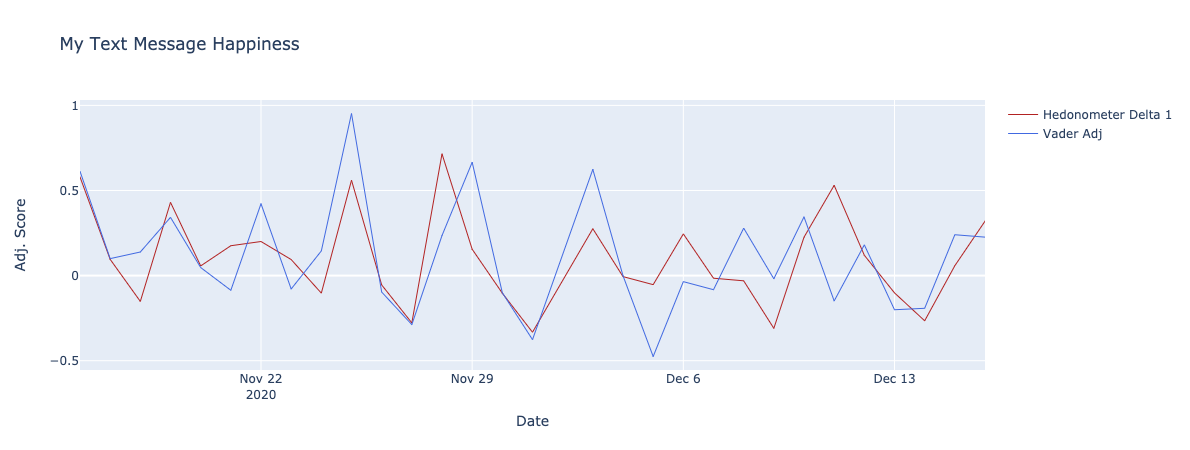

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score_normalized
    , name='Hedonometer Delta 1'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.compound_score_normalized
    , name='Vader Adj'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='My Text Message Happiness',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

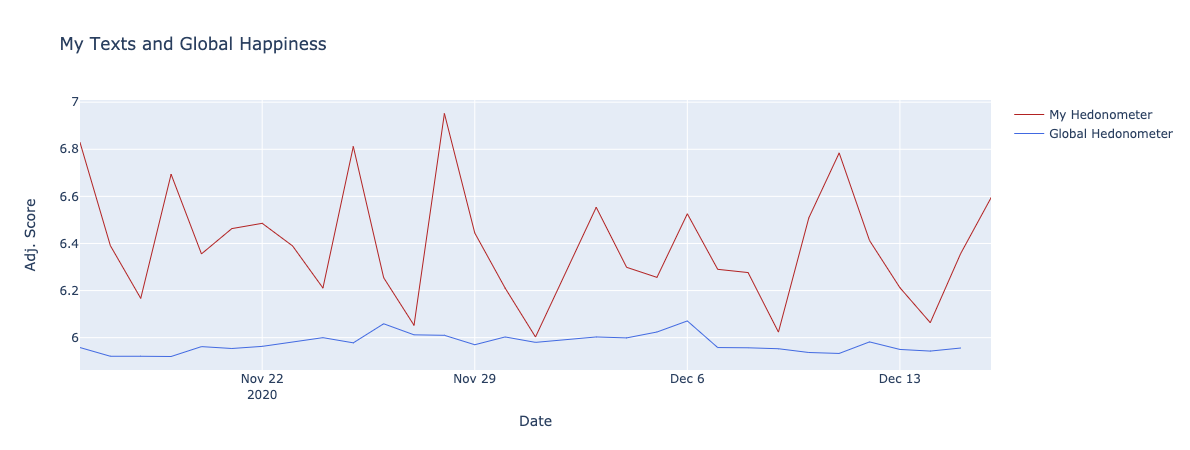

In [46]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.hedonometer_score
    , name='My Hedonometer'
   , line=dict(color='firebrick', width=1))
)


fig.add_trace(go.Scatter(
    x=gdf.index.values
    , y=gdf.global_hedonometer_score
    , name='Global Hedonometer'
   , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='My Texts and Global Happiness',
                   xaxis_title='Date',
                   yaxis_title='Adj. Score')

fig.show()

In [47]:
### NY Times
nyt_creds = yaml.load(open(os.path.expanduser('~/.nyt/creds.yml'),'r'), Loader=yaml.FullLoader)

In [48]:
nyt_url = "https://api.nytimes.com/svc/archive/v1/{year}/{month_num}.json"
# print(nyt_url.format(**{'year': '2020', 'month_num':1}))
params = {
    'api-key': nyt_creds['api-key']
}

### let's get all the news
nyt_data = []

total_months = math.ceil((dt.datetime.today() - dt.datetime(2018,1,1)).days/30)
start_time = dt.datetime.now()
for i in range(total_months):
    month_num = (dt.datetime.today() - dt.timedelta(days=30*i)).month
    year_num = (dt.datetime.today() - dt.timedelta(days=30*i)).year

    r = requests.get(
        url = nyt_url.format(**{'year': year_num, 'month_num': month_num})
        , params = params
    ) 
    
    response_json = json.loads(r.text)
    if 'response' in response_json.keys():
        if 'docs' in response_json['response'].keys():
            nyt_data = nyt_data + response_json['response']['docs']
        
total_time = (dt.datetime.now() - start_time).seconds

print(f'total time secs = {total_time}')

total time secs = 225


In [49]:
nyt_df = pd.DataFrame(data=nyt_data)
nyt_df.shape

(166410, 20)

In [50]:
# calc some fields 
nyt_df['published_datetime'] = pd.to_datetime(nyt_df.pub_date)

# headlines
nyt_df['hedonometer_frequency'] = nyt_df.headline.apply(lambda x: get_word_ct(x['main'], hed_dict,1))
nyt_df['hedonometer_total_score'] = nyt_df.headline.apply(lambda x: get_total_word_score(x['main'], hed_dict,1))
nyt_df['hedonometer_score'] = nyt_df.hedonometer_total_score/nyt_df.hedonometer_frequency
nyt_df['hedonometer_dict'] = nyt_df.headline.apply(lambda x: get_hedonometer_word_dict(x['main'], hed_dict, 1))

# lead paragraphs
nyt_df['hedonometer_frequency_lp'] = nyt_df.lead_paragraph.apply(lambda x: get_word_ct(x, hed_dict,1))
nyt_df['hedonometer_total_score_lp'] = nyt_df.lead_paragraph.apply(lambda x: get_total_word_score(x, hed_dict,1))
nyt_df['hedonometer_score_lp'] = nyt_df.hedonometer_total_score_lp/nyt_df.hedonometer_frequency_lp
nyt_df['hedonometer_dict_lp'] = nyt_df.lead_paragraph.apply(lambda x: get_hedonometer_word_dict(x, hed_dict, 1))

# messages_df['vader_score'] = messages_df.text.apply(lambda x: analyser.polarity_scores(x))
nyt_df['compound_score'] = nyt_df.headline.apply(lambda x: get_vader_compound_score(x['main']))

In [57]:
nyt_by_day = nyt_df.groupby(nyt_df.published_datetime.dt.date).agg(
    {
        'compound_score': 'mean',
        'hedonometer_score': 'mean', 
        'hedonometer_score_lp': 'mean', 
    }
)

# hedonommeter score dict
hed_score_dict = hed_df.set_index(hed_df.datetime.dt.date).T.to_dict()
hed_event_dict = hed_df2.set_index(hed_df2.datetime.dt.date).T.to_dict()

# add scores
nyt_by_day['date'] = nyt_by_day.index.values
nyt_by_day['global_hedonometer_score'] = nyt_by_day.date.apply(lambda x: hed_score_dict[x]['happiness'] if x in hed_score_dict.keys() else None)
nyt_by_day['global_hedonometer_event_shorter'] = nyt_by_day.date.apply(lambda x: hed_event_dict[x]['shorter'] if x in hed_event_dict.keys() else None)

nyt_by_day['hedonometer_score_30d'] = nyt_by_day.hedonometer_score.rolling(window=30, min_periods=30).mean()
nyt_by_day['hedonometer_score_lp_30d'] = nyt_by_day.hedonometer_score_lp.rolling(window=30, min_periods=30).mean()
nyt_by_day['global_hedonometer_score_30d'] = nyt_by_day.global_hedonometer_score.rolling(window=30, min_periods=30).mean()

In [54]:
nyt_by_day.head(10)

compound_score  hedonometer_score  hedonometer_score_lp  \
published_datetime                                                            
2018-01-01               -0.041791           5.731841              5.944222   
2018-01-02               -0.008817           5.871745              6.120740   
2018-01-03               -0.041125           5.527041              5.914487   
2018-01-04               -0.047491           5.789875              5.931195   
2018-01-05               -0.001416           5.953981              6.087851   
2018-01-06               -0.027634           5.637661              5.860300   
2018-01-07                0.025618           5.789660              6.040555   
2018-01-08               -0.027975           5.711952              5.999669   
2018-01-09               -0.009257           5.847772              6.132490   
2018-01-10               -0.036888           5.755297              5.994090   

                          date global_hedonometer_score  \
published_datetime                                        
2018-01-01          2018-01-01                    6.081   
2018-01-02          2018-01-02                    5.951   
2018-01-03          2018-01-03                    5.969   
2018-01-04          2018-01-04                    5.989   
2018-01-05          2018-01-05                    6.008   
2018-01-06          2018-01-06                    5.988   
2018-01-07          2018-01-07                    6.005   
2018-01-08          2018-01-08                    6.016   
2018-01-09          2018-01-09                    6.011   
2018-01-10          2018-01-10                    6.023   

                   global_hedonometer_event_longer  hedonometer_score_30d  \
published_datetime                                                          
2018-01-01                                    None                    NaN   
2018-01-02                                    None                    NaN   
2018-01-03                                    None                    NaN   
2018-01-04                                    None                    NaN   
2018-01-05                                    None                    NaN   
2018-01-06                                    None                    NaN   
2018-01-07                                    None                    NaN   
2018-01-08                                    None                    NaN   
2018-01-09                                    None                    NaN   
2018-01-10                                    None                    NaN   

                    hedonometer_score_lp_30d  global_hedonometer_score_30d  
published_datetime                                                          
2018-01-01                               NaN                           NaN  
2018-01-02                               NaN                           NaN  
2018-01-03                               NaN                           NaN  
2018-01-04                               NaN                           NaN  
2018-01-05                               NaN                           NaN  
2018-01-06                               NaN                           NaN  
2018-01-07                               NaN                           NaN  
2018-01-08                               NaN                           NaN  
2018-01-09                               NaN                           NaN  
2018-01-10                               NaN                           NaN

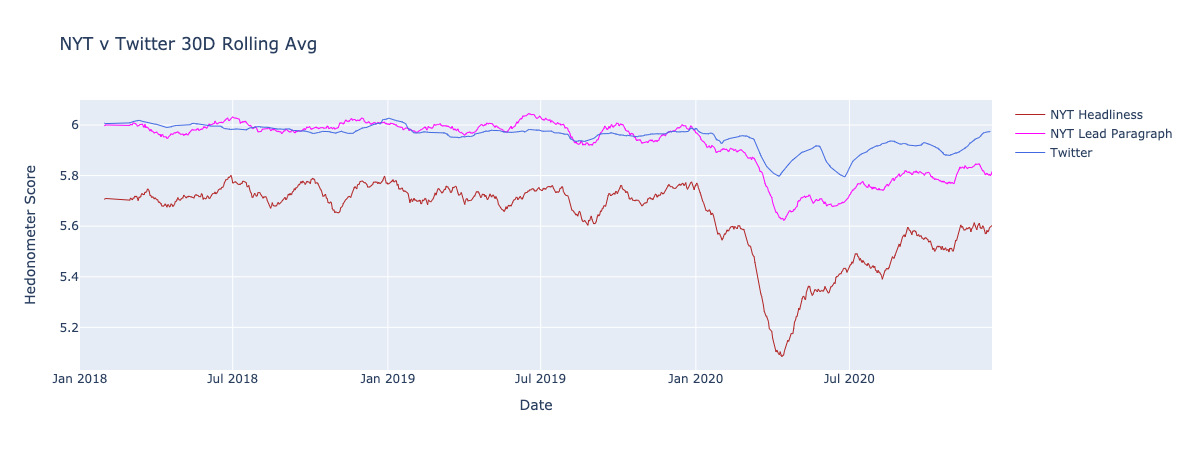

In [61]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.hedonometer_score_30d
    , name='NYT Headliness'
   , line=dict(color='firebrick', width=1))
)

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.hedonometer_score_lp_30d
    , name='NYT Lead Paragraph'
   , line=dict(color='magenta', width=1))
)

fig.add_trace(go.Scatter(
    x=nyt_by_day.index.values
    , y=nyt_by_day.global_hedonometer_score_30d
    , name='Twitter'
#     , text=nyt_by_day.global_hedonometer_event_shorter
#     , mode="lines+text"
    , line=dict(color='royalblue', width=1))
)

# Edit the layout
fig.update_layout(title='NYT v Twitter 30D Rolling Avg',
                   xaxis_title='Date',
                   yaxis_title='Hedonometer Score')

fig.show()

In [67]:
## worst day
nyt_df[
    (nyt_df.published_datetime.dt.date == dt.date(2020,4,15))
].sort_values('hedonometer_score_lp', ascending=True)[['headline'
                                                    ,'hedonometer_score'
                                                    ,'hedonometer_dict'
                                                    , 'lead_paragraph'
                                                    , 'hedonometer_score_lp'
                                                    ,'hedonometer_dict_lp',
                                                   ]].head(3).T.to_dict()

{37478: {'headline': {'main': 'In Argentina, a Bid to Make Language Gender Neutral Gains Traction',
   'kicker': None,
   'content_kicker': None,
   'print_headline': 'Can the Letter E Change the World? A Rising Movement Hopes So',
   'name': None,
   'seo': None,
   'sub': None},
  'hedonometer_score': 6.7,
  'hedonometer_dict': {'words': {'Language': 6.58, 'Gains': 6.82}, 'freq': 2},
  'lead_paragraph': 'BUENOS AIRES — Three days into Argentina’s coronavirus lockdown, the country’s president called on men and women, Argentinos and Argentinas, to cooperate with the effort.',
  'hedonometer_score_lp': 1.34,
  'hedonometer_dict_lp': {'words': {'coronavirus': 1.34}, 'freq': 1}},
 37497: {'headline': {'main': 'Ultra-Orthodox Enclave in Israel Opens to Outsiders to Fight a Virus',
   'kicker': 'Bnei brak dispatch',
   'content_kicker': None,
   'print_headline': 'Virus Forces Ultra-Orthodox Enclave to Call on Unlikely Ally: The Army',
   'name': None,
   'seo': None,
   'sub': None},
  'he

In [66]:
## best day
nyt_df[
    (nyt_df.published_datetime.dt.date == dt.date(2019,6,21))
].sort_values('hedonometer_score_lp', ascending=False)[['headline'
                                                    ,'hedonometer_score'
                                                    ,'hedonometer_dict'
                                                    , 'lead_paragraph'
                                                    , 'hedonometer_score_lp'
                                                    ,'hedonometer_dict_lp',
                                                   ]].head(3).T.to_dict()

{83176: {'headline': {'main': 'Jill Lepore on the 50th Anniversary of the Moon Landing',
   'kicker': None,
   'content_kicker': None,
   'print_headline': '',
   'name': None,
   'seo': None,
   'sub': None},
  'hedonometer_score': 6.99,
  'hedonometer_dict': {'words': {'Anniversary': 6.7, 'Moon': 7.28}, 'freq': 2},
  'lead_paragraph': 'Subscribe: iTunes | Google Play Music | How to Listen',
  'hedonometer_score_lp': 7.493333333333333,
  'hedonometer_dict_lp': {'words': {'Google': 7.2,
    'Play': 7.26,
    'Music': 8.02},
   'freq': 3}},
 83103: {'headline': {'main': 'Summer’s Finally Here. So Where Is It?',
   'kicker': None,
   'content_kicker': None,
   'print_headline': 'In an Unseasonably Soggy June, Summer Officially, Gloomily Begins',
   'name': None,
   'seo': None,
   'sub': None},
  'hedonometer_score': nan,
  'hedonometer_dict': {'words': {}, 'freq': 0},
  'lead_paragraph': 'Somewhere, supposedly, the sun still shines over New York City — though this week, it would have be